# Limpieza Datos de las Transacciones
#### JJD-Predictors

### Lectura y Adecuación de los datos.

Lectura de los datos correspondientes a las transacciones como un DataFrame usando la librería pandas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from unicodedata import normalize

%matplotlib inline

metada_transactions = pd.read_excel("Metadatos_Tabla2.xlsx")
data_transactions = pd.read_csv("dt_trxpse_personas_2016_2018_muestra_adjt.csv", error_bad_lines = False, warn_bad_lines = False,
                                names=range(0,12))

Creación de un diccionario con el nombre de las columnas en el archivo **Metadatos_Tabla2.xlsx** para asignar al DataFrame. Se encontró que los datos poseen algunos una segunda descripción, por ende se agregó una nueva columna llamada descripcion2.

In [2]:
dict_header = dict()
list_header = list(metada_transactions.name)
for i,element in enumerate(list_header):
    dict_header[i] = element
    
data_transactions = data_transactions.rename(columns = dict_header)

Conversión de la columna fecha al tipo de dato respectivo con la función de pandas *to_datetime*.

In [3]:
data_transactions["fecha"] = pd.to_datetime(data_transactions["fecha"], format="%Y%m%d", errors = 'ignore')

Al observar los datos correspondientes a la hora se observa que hay decimales con menos de seis dígitos, por ende se completan estos valores con ceros al inicio. Por otra parte, observando que la columna *ref3* solo contiene valores nulos se elimina del conjunto de datos. 

In [4]:
data_transactions["hora"] = data_transactions["hora"].astype('str')
data_transactions["hora"] = data_transactions["hora"].apply(lambda x : '0'*(6 - len(x)) + x)
data_transactions["hora"] = data_transactions["hora"].apply(lambda x : x[:2] + ":" + x[2:4])
data_transactions = data_transactions.drop(["ref3"], axis = 1)

A cada columna de acuerdo a los datos que contiene se le asigna el tipo de dato correspondiente.  

In [ ]:
data_transactions["id_cliente"] = data_transactions.id_cliente.astype('int',  errors = 'ignore')
data_transactions["valor_trx"] = data_transactions["valor_trx"].astype('float64', errors = 'ignore')
data_transactions["ref1"] = data_transactions["ref1"].astype('str')
data_transactions["ref2"] = data_transactions["ref2"].astype('str')
data_transactions["sector"] = data_transactions["sector"].astype('str')
data_transactions["subsector"] = data_transactions["subsector"].astype('str')
data_transactions["descripcion"] = data_transactions["descripcion"].astype('str')
data_transactions["descripcion2"] = data_transactions["descripcion2"].astype('str')

Se reemplazan todos los valores que contienen '\\N' o '\\n' dentro del conjunto de datos por nan.

In [6]:
data_transactions = data_transactions.replace({'\\N': np.nan,'\\n': np.nan})

Se eliminan los datos que no contienen información de id_trn_ach, id_cliente, fecha y valor_trx.

In [7]:
data_transactions = data_transactions[~data_transactions['id_trn_ach'].isnull()]
data_transactions = data_transactions[~data_transactions['id_cliente'].isnull()]
data_transactions = data_transactions[~data_transactions['fecha'].isnull()]
data_transactions = data_transactions[~data_transactions['valor_trx'].isnull()]

Los datos de las columnas *ref1* y *ref2*, se convierten todos a minúscula (*lower( )*). Posteriormente, se elimina el guión bajo para separar las frases que vienen unidas (*replace( )*) y los caracteres no deseados (*sub( )*). Aquellas abreviaciones como cc,ce,idc,entre otras, que se identificaron y se consideró no son relevantes en el análisis, se reemplazan por nan y finalmente se suprimen los espacios en blanco al inicio y al final (*strip( )*).

In [8]:
data_transactions["ref1"] = data_transactions["ref1"].apply(lambda x: x.lower())
data_transactions['ref1'] = data_transactions.ref1.str.replace('_',' ')
data_transactions["ref1"] = data_transactions["ref1"].apply(lambda s: re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
                                                                             normalize( "NFD", s), 0, re.I))
data_transactions["ref1"] = data_transactions["ref1"].str.replace(r'(( |^)(cc|ce|idc|ti|nit|pp|pt|rc|TPNI|null|A|B|C|id|DE|NUIP|FM)( |$))|\|','')  
data_transactions["ref1"] = data_transactions["ref1"].apply(lambda x: x.strip())  
data_transactions["ref1"] = data_transactions["ref1"].replace({"nan":np.nan, '':np.nan}) 

In [9]:
data_transactions["ref2"] = data_transactions["ref2"].apply(lambda x: x.lower())
data_transactions["ref1"] = data_transactions.ref1.str.replace('_',' ')
data_transactions["ref2"] = data_transactions["ref2"].apply(lambda s: re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
                                                                             normalize( "NFD", s), 0, re.I))
data_transactions["ref2"] = data_transactions["ref2"].str.replace(r'(( |^)(cc|ce|idc|ti|nit|pp|pt|ni|rc|tpni|null|A|B|C|id|DE|NUIP|FM)( |$))|\|','')  
data_transactions["ref2"] = data_transactions["ref2"].apply(lambda x: x.strip())  
data_transactions["ref2"] = data_transactions["ref2"].replace({"nan":np.nan, '':np.nan}) 

Para las otras columnas se reeemplazan los espacios vacios y los string 'nan' por np.nan.

In [10]:
data_transactions["sector"] = data_transactions["sector"].replace({"nan":np.nan, '':np.nan}) 
data_transactions["subsector"] = data_transactions["subsector"].replace({"nan":np.nan, '':np.nan}) 
data_transactions["descripcion"] = data_transactions["descripcion"].replace({"nan":np.nan, '':np.nan}) 
data_transactions["descripcion2"] = data_transactions["descripcion2"].replace({"nan":np.nan, '':np.nan}) 

Se eliminan todas las filas con valores nulos tanto en *ref1* como en *ref2* y posteriormente, aquellas solo con valores nulos en *ref1*.

In [11]:
data_transactions = data_transactions[(~data_transactions['ref1'].isnull()) | (~data_transactions['ref2'].isnull())]
data_transactions = data_transactions[(~data_transactions['ref1'].isnull())]

Se observa el número de datos después de la limpieza realizada a los datos.

In [12]:
data_transactions.size

111873014

Para procesar los datos ingresados en los campos de referencia (*ref1* y *ref2*), se eliminan las *stopwords*, que se refiere a aquellas palabras sin significado como las preposiciones o artículos en español.

In [14]:
from nltk.corpus import stopwords
sw = stopwords.words('spanish')
data_transactions["ref1"] = data_transactions["ref1"].apply(lambda x: ' '.join(str(e) for e in [word for word in str.split(x) if word not in sw]))

In [15]:
data_transactions["ref2"] = data_transactions["ref2"].astype('str',  errors = 'ignore')
data_transactions["ref2"] = data_transactions["ref2"].apply(lambda x: ' '.join(str(e) for e in [word for word in str.split(x) if word not in sw]))

Los datos en la columna *ref2* que aparecen muy pocas veces, es decir que son únicos se observó que normalmente eran nombres de personas, correos, o datos sin relevancia. Por ende, se filtraron aquellos datos que no se encontraron repetidos más de 60 veces y se guardan en un archivo pkl.

In [16]:
filtered = data_transactions.groupby('ref2').filter(lambda x: len(x) < 60).ref2
data_transactions.loc[data_transactions['ref2'].isin(filtered),'ref2']= ''
data_transactions["ref2"] = data_transactions["ref2"].replace({"nan":np.nan, '':np.nan})
del filtered 
data_transactions.to_pickle('./transactions_BC_preclean.pkl')

Habiendo limpiado los datos de las columnas de referencia, se unen las columnas *ref1* y *ref2* en una sola con nombre *ref* y se procede a limpiar esta columna. 

In [2]:
data_transactions["ref2"] = data_transactions["ref2"].fillna(value="")
data_transactions["ref"] = data_transactions["ref1"] + " " + data_transactions["ref2"] 
data_transactions["ref"] = data_transactions["ref"].apply(lambda x: x.strip())

In [3]:
data_transactions = data_transactions.drop(['ref1', 'ref2'],axis=1)
data_transactions["ref"] = data_transactions["ref"].replace({"nan":np.nan, '':np.nan}) 

En caso de que queden datos nulos en *ref* se eliminan. 

In [4]:
data_transactions = data_transactions[~data_transactions['ref'].isnull()]

Para filtrar las transacciones con errores, se eliminan todas aquellas que correspondan a valores menores a 1600.

In [ ]:
minimum_trx = 1600
data_transactions["valor_trx"] = data_transactions["valor_trx"].astype('float64', errors = 'ignore')
data_transactions = data_transactions.loc[(data_transactions["valor_trx"]>minimum_trx)]

Por otra parte, como se tienen los valores de las transacciones se decide estudiar el comportamiento de estos datos para observar si existen datos atípicos. Para esto, se utilliza un diagrama cajas. 

{'boxes': [<matplotlib.lines.Line2D at 0x2165ee216d8>],
 'caps': [<matplotlib.lines.Line2D at 0x2165edeb320>,
 'fliers': [<matplotlib.lines.Line2D at 0x2165eda9668>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x2165edce4e0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x2165ee14b38>,
  <matplotlib.lines.Line2D at 0x2165edfa550>]}

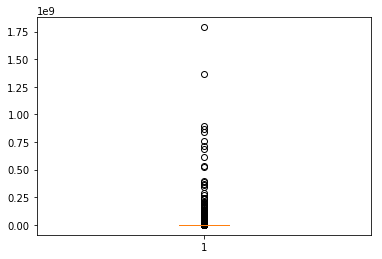

In [6]:
trxs = data_transactions["valor_trx"] 
plt.boxplot(trxs, showfliers = True)

Al verificar que efectivamente se tienen valores atípicos, usamos el método que se basa en el rango intercuartil para filtrar los datos que se desvían de la media encontrada, creando una función denominada *outlier_detection* y se dibuja nuevamente un diagrama de cajas. 

{'boxes': [<matplotlib.lines.Line2D at 0x2165ea378d0>],
 'caps': [<matplotlib.lines.Line2D at 0x2165e9f8b38>,
 'fliers': [<matplotlib.lines.Line2D at 0x2165e9b2588>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x2165e9cf518>],
 'whiskers': [<matplotlib.lines.Line2D at 0x2165ea315f8>,
  <matplotlib.lines.Line2D at 0x2165ea11e48>]}

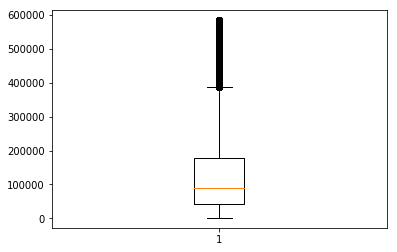

In [7]:
def outlier_detection(df, column_name):
    q3=df[column_name].quantile(0.75)
    q1=df[column_name].quantile(0.25)
    IQR=q3-q1
    a=q1-1.5*(IQR)
    b=q3+1.5*(IQR)
    df_f =df.loc[(df[column_name]>a)&(df[column_name]<=b)]
    return df_f

data_transactions = outlier_detection(data_transactions, "valor_trx")
trxs = data_transactions["valor_trx"]
plt.boxplot(trxs, showfliers = True)

Se observa de nuevo la cantidad de datos al limpiar datos atípicos en las transacciones y el porcentaje de valores nulos por columna. Finalmente, se resetea el indice de los datos. 

In [8]:
print(data_transactions.size)
100*data_transactions.isnull().mean()
data_transactions = data_transactions.reset_index(drop=True)

86773260


id_trn_ach       0.000000
id_cliente       0.000000
fecha            0.000000
hora             0.000000
valor_trx        0.000000
sector          66.411035
subsector       66.411035
descripcion     66.411035
descripcion2    99.812615
ref              0.000000
dtype: float64

In [10]:
data_transactions.to_pickle("./transactions_BC_preclean.pkl")
data_transactions.to_csv("./transactions_BC_preclean.csv", encoding="utf-8")